<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обзор данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание новых признаков</a></span></li><li><span><a href="#Проверка-ряда-на-стационарность" data-toc-modified-id="Проверка-ряда-на-стационарность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка ряда на стационарность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Моделирование</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Задачи:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


## Подготовка

Загрузка необходимых в работе библиотек

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.stattools import adfuller

In [2]:
RANDOM_STATE = 123

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Обзор данных

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные предоставлены за период с марта по август 2018 года

## Анализ

### Анализ данных

Просемплируем данные по часам:

(Так как график по часам очень шумный на большом отрезке времени, рассмотрим данные за 1 месяц)

In [7]:
data_hours = data.resample('1H').sum()

In [8]:
data_hours['mean'] = data_hours['num_orders'].shift().rolling(20).mean()
data_hours['std'] = data_hours['num_orders'].shift().rolling(20).std()

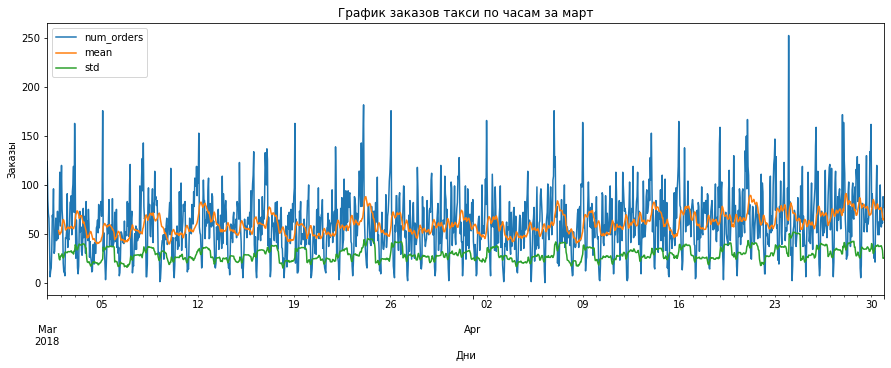

In [9]:
data_hours['2018-03':'2018-04'].plot(figsize=(15, 5))
plt.title('График заказов такси по часам за март')
plt.xlabel('Дни')
plt.ylabel('Заказы');

По графику за такой короткий пириод нельзя сделать вывод о стационарности временного ряда. 

Просемплируем данные по дням:

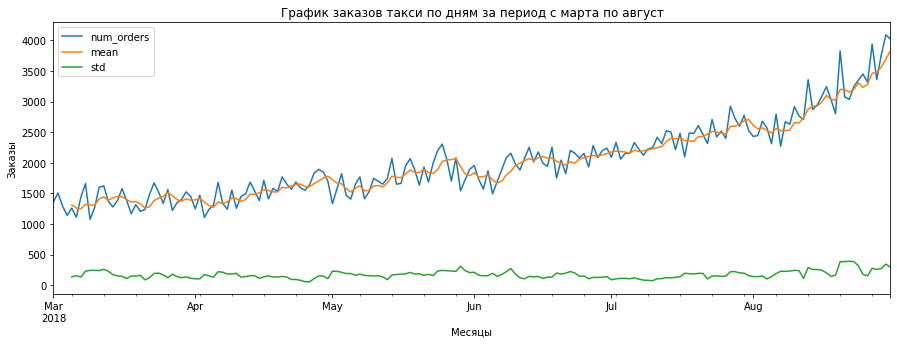

In [10]:
data_days = data.resample('1D').sum()
data_days['mean'] = data_days['num_orders'].rolling(5).mean()
data_days['std'] = data_days['num_orders'].rolling(5).std()
data_days.plot(figsize=(15, 5))
plt.title('График заказов такси по дням за период с марта по август')
plt.xlabel('Месяцы')
plt.ylabel('Заказы');

Как видно из графика среднее значение заказов такси по дням растет, можно сделать вывод, что временной ряд нестационарен

Разобьем врекменной ряд на тренд и сезонность:

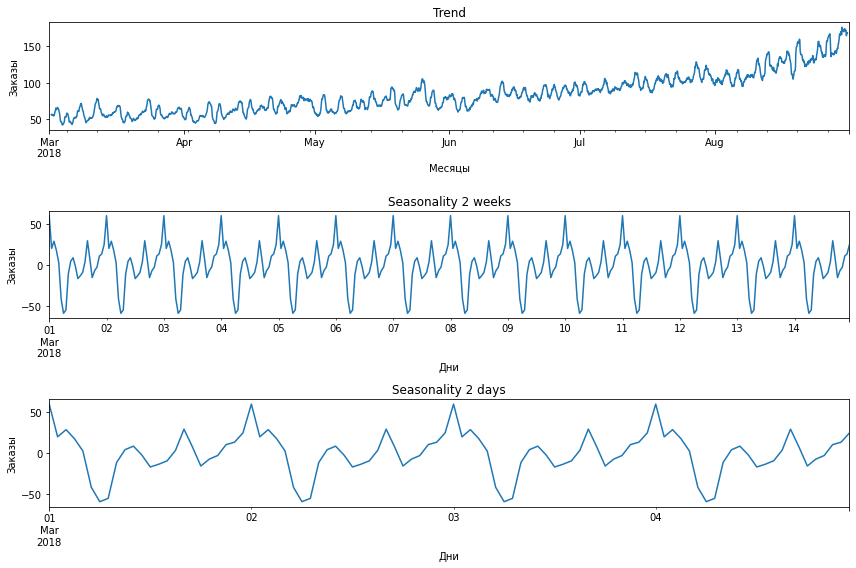

In [11]:
decomposed = seasonal_decompose(data_hours['num_orders'])
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Месяцы')
plt.ylabel('Заказы')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
plt.title('Seasonality 2 weeks')
plt.xlabel('Дни')
plt.ylabel('Заказы')
plt.subplot(313)
decomposed.seasonal['2018-03-01':'2018-03-04'].plot(ax=plt.gca())
plt.title('Seasonality 2 days')
plt.xlabel('Дни')
plt.ylabel('Заказы')
plt.tight_layout();

- Тренд растет от месяца к месяцу - среднее количество заказов такси за рассматриваемый период постоянно растет
- По графику сезонности видно, что в течение дня есть 3 пиковые точки с максимальной загруженностью
- Самые загруженные часы - ночью и рано утром

### Создание новых признаков

Создание новых признаков

Напишем функцию, с помощью которой добавим следующие принзнаки:
1. Календарные признаки
2. «Отстающие значения»
3. Скользящее среднее (Не включая текущее значение ряда)

In [12]:
data_model = data.resample('1H').sum()

def make_features(data, max_lag, rolling_mean_size):
#     data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift()

In [13]:
make_features(data_model, 7, 20)
print(data_model.head())

                     num_orders  day  dayofweek  hour  lag_1  rolling_mean  \
datetime                                                                     
2018-03-01 00:00:00         124    1          3     0    NaN           NaN   
2018-03-01 01:00:00          85    1          3     1  124.0           NaN   
2018-03-01 02:00:00          71    1          3     2   85.0           NaN   
2018-03-01 03:00:00          66    1          3     3   71.0           NaN   
2018-03-01 04:00:00          43    1          3     4   66.0           NaN   

                     lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  
datetime                                                       
2018-03-01 00:00:00    NaN    NaN    NaN    NaN    NaN    NaN  
2018-03-01 01:00:00    NaN    NaN    NaN    NaN    NaN    NaN  
2018-03-01 02:00:00  124.0    NaN    NaN    NaN    NaN    NaN  
2018-03-01 03:00:00   85.0  124.0    NaN    NaN    NaN    NaN  
2018-03-01 04:00:00   71.0   85.0  124.0    NaN    NaN    NaN  


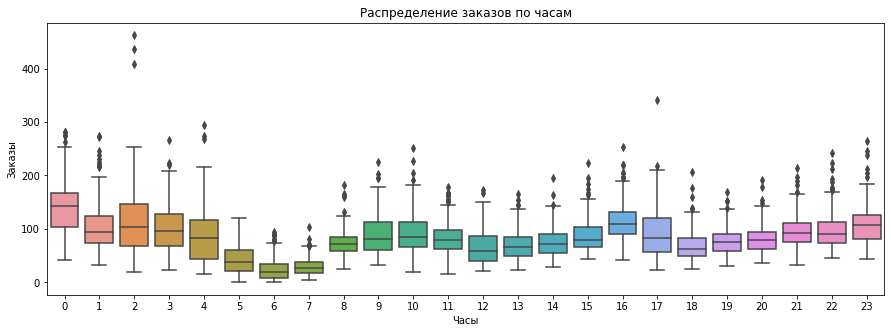

In [14]:
plt.figure(figsize=(15,5))
sns.boxplot(y='num_orders', x='hour', data=data_model)
plt.title('Распределение заказов по часам')
plt.xlabel('Часы')
plt.ylabel('Заказы');

Самое большое количество заказов в ночное время и в начале и в конце рабочего дня. 
В 2 часа ночи иногда отмечается рекордное количество заказов - заметные выбросы

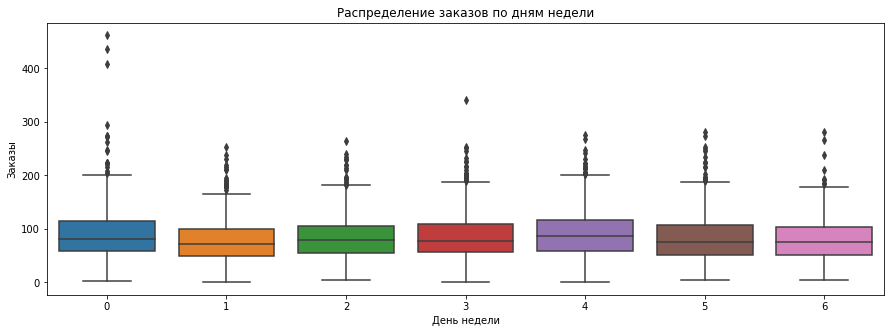

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(y='num_orders', x='dayofweek', data=data_model)
plt.title('Распределение заказов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Заказы');

Среднее количество заказов практически не различается по дням недели

### Проверка ряда на стационарность

Проведем тест Дики-Фуллера на стационарность

Сформулируем нулевую и альтернативную гипотезы:

H0: Временной ряд обладает единичным корнем (unit root), не стационарен

H1: Временной ряд НЕ обладает единичным корнем (unit root), стационарен

In [16]:
st_test = adfuller(data_model['num_orders'])
print('ADF Statistic: %f' % st_test[0])
print('p-value: %f' % st_test[1])
print('Critical Values:')
for key, value in st_test[4].items():
    print('\t%s: %.3f' % (key, value))
 
if st_test [0]> st_test [4]['1%']:
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

ADF Statistic: -3.068924
p-value: 0.028940
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
есть единичные корни, ряд не стационарен


## Обучение

### Моделирование

In [17]:
data_model = data_model.dropna()
X_train, X_test, y_train, y_test = train_test_split(data_model.drop(['num_orders'], axis=1),
                               data_model['num_orders'],
                               shuffle=False,
                               test_size=0.1)

print(X_train.index.min(), X_train.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-01 20:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


Данные поделены корректно: тренировочная выборка заканчивается там, где начинается тестовая

In [18]:
pipe_final = Pipeline([
    ('models', LinearRegression())
])

param_grid = [
    # словарь для модели RandomForestRegressor()
    {
     'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 20, 2),
     'models__n_estimators':[50, 100],
     'models__min_samples_split': range(2, 10, 2),
     'models__min_samples_leaf': range(2, 10, 2)
    },
    # словарь для модели DecisionTreeRegressor()
    {
     'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
     'models__max_depth': range(2, 10, 2),
     'models__max_features': range(2, 10, 2),
     'models__min_samples_split': range(2, 10, 2),
     'models__min_samples_leaf': range(2, 10, 2)
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()]
    },
]

In [19]:
tcv = TimeSeriesSplit(n_splits=5)

In [20]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    cv=tcv,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -1*randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 RandomForestRegressor(max_depth=18, min_samples_leaf=2,
                                       min_samples_split=8,
                                       random_state=123))])
Метрика лучшей модели на тренировочной выборке: 25.59869358144284


## Тестирование

In [21]:
pred = randomized_search.predict(X_test)
print('Метрика лучшей модели на тестовой выборке:', mean_squared_error(y_test, pred)**0.5)

Метрика лучшей модели на тестовой выборке: 44.55773190527811


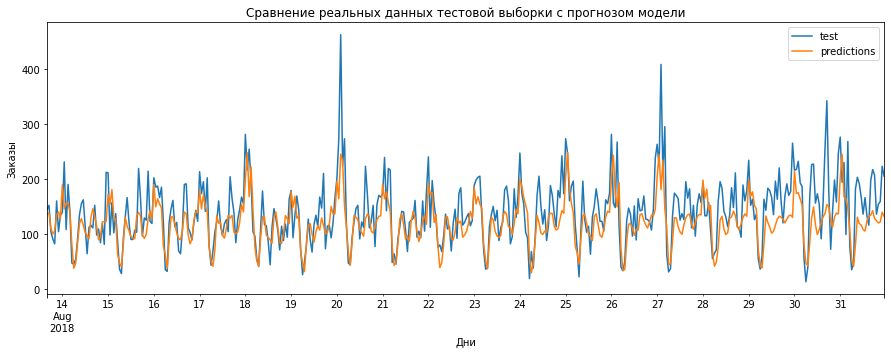

In [22]:
result=pd.DataFrame(zip(y_test, pred), columns=['test', 'predictions'], index=(y_test.index))
result.plot(figsize=(15, 5))
plt.xlabel('Дни')
plt.ylabel('Заказы')
plt.title('Сравнение реальных данных тестовой выборки с прогнозом модели');

In [23]:
dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict_dummy_mean = dummy_mean.predict(X_test) 
print(f'Метрика на константной модели: {mean_squared_error(y_test, y_predict_dummy_mean)** 0.5}')

Метрика на константной модели: 84.69056594015109


## Итоговый вывод

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки.

Задача была спрогнозировать количество заказов такси на следующий час. 

Были выполены следующие этапы:

1. Загрузка, обзор данных и их ресемплирование.

Данные предоставлены за период с марта по август 2018 года

2. Анализ данных.

- Тренд растет от месяца к месяцу - среднее количество заказов такси за рассматриваемый период постоянно растет
- По графику сезонности видно, что в течение дня есть 3 пиковые точки с максимальной загруженностью
- Самые загруженные часы - ночью и рано утром
- Самое большое количество заказов в ночное время и в начале и в конце рабочего дня. В 2 часа ночи иногда отмечается рекордное количество заказов - заметные выбросы
- Среднее количество заказов практически не различается по дням недели

Как видно из графиков тренда и среднего значения заказов такси по дням, эти показатели растут, можно сделать вывод, что временной ряд нестационарен.

Также был проведен тест Дики-Фуллера на стационарность, по результатам коротого изучаемый временной ряд стационарным не является. Этот тест подтвердил нестационарность ряда, наблюдаемую по росту труенда и среднего значения по дням.

В процессе работы были созданы новые признаки:
- Календарные признаки
-  «Отстающие значения»
- Скользящее среднее (Не включая текущее значение ряда)

3. Обучение моделей с различными гиперпараметрами. 
Тестовая выборка взята размером 10% от исходных данных. Данные поделены корректно: тренировочная выборка заканчивается там, где начинается тестовая.
В процессы моделирование были исследованы модели: RandomForestRegressor, DecisionTreeRegressor, LinearRegression.

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 RandomForestRegressor(max_depth=18, min_samples_leaf=2,
                                       min_samples_split=8,
                                       random_state=123))])
                                       
4. Проверка лучшей модели на тестовых данных.

Метрика лучшей модели на тестовой выборке: 44.55773190527811

Модель хорошо прогнозирует часы с низким количеством заказов и часы средней загрузки. Хуже всего модель справляется именно с пиковыми загруженными часами. Сама форма кривой прогноза корректная и пиковые часы можно увидеть, однако модель только занижаниет непосредственно количество заказов в это время.